In [1]:
import os
import tensorflow as tf
import itertools
import numpy as np
from numpy import unravel_index
from random import choice, random
np.random.seed(1337)  # for reproducibility
from keras.datasets import cifar100
from keras.models import Sequential, Model, load_model
from keras.layers import Input, BatchNormalization, Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AlphaDropout, ConvLSTM2D, AvgPool2D, Conv2DTranspose, UpSampling2D
from keras.layers import add, concatenate
from keras.initializers import VarianceScaling, RandomUniform
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.regularizers import l1, l2
import keras.backend as K
K.set_image_dim_ordering('th')

from keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import time
%matplotlib notebook

Using TensorFlow backend.


In [2]:
class Ataxx:
    def __init__(self, board=None):
        if board is None:                  # if there is no initialization given
            self.data = np.zeros((7, 7))   # then generate a board with starting init, and black(-1) takes first turn
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board
    
    def plot(self, is_next_move=False, turn=None):                        # plot the board
        image = self.data.copy()
        if is_next_move:
            if turn not in [-1, 1]:
                raise ValueError("Turn must be -1 or 1, or Must input a turn for next moves")
            else:
                next_moves = self.get_moves(turn)
                if len(next_moves) == 0:
                    raise ValueError("Game is over already")
                next_pos = list(zip(*next_moves))[1]
                for pos in next_pos:
                    image[pos] = turn / 2
        plt.imshow(image, cmap='gray')
        plt.xticks(range(7), range(7))
        plt.yticks(range(7), range(7))
        plt.show()
                
    def is_valid(self, turn, pos):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif self.data[pos] != 0:
            return False
        else:
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    pos_tmp = (pos[0]+dr, pos[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if self.data[pos_tmp] == turn:  # convert any piece of the opponent to 'turn'
                            return True
            return False
        
    def get_moves(self, turn):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1")# return a list of tuples of tuple
        else:
            next_moves = []
            for r in range(7):
                for c in range(7):
                    has_duplicate_move = False      # move within the radius of one of another friendly piece is called
                    if self.is_valid(turn, (r, c)): # duplicate move
                        for dr in range(-2, 3):
                            for dc in range(-2, 3):
                                if abs(dr) <= 1 and abs(dc) <=1 and has_duplicate_move: 
                                    continue        # no need to record same move again
                                else:
                                    pos_tmp = (r+dr, c+dc)
                                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                                        if self.data[pos_tmp] == turn:
                                            next_moves.append((pos_tmp, (r, c)))
            return next_moves
    
    def get_greedy_move(self, turn):
        moves = self.get_moves(turn)
        store_data = self.data.copy()
        best_score = -1001
        for move in moves:
            self.data = store_data.copy()
            self.move_to(turn, move[0], move[1])
            score = self.evaluate(turn, -turn)
            if score > best_score:
                best_move = move
                best_score = score
        self.data = store_data
        return best_move
        
    def move_to(self, turn, pos0, pos1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str(pos1) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[pos0] != turn:
            raise ValueError("The starting position is not your piece")
        else:
            dis = np.array(pos1) - np.array(pos0)    # check if is jump move or duplicate move
            if abs(dis[0]) > 1 or abs(dis[1]) > 1:   # jump move
                self.data[pos0] = 0
                self.data[pos1] = turn
            else:                                    # duplicate move
                self.data[pos1] = turn
            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    pos_tmp = (pos1[0]+dr, pos1[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if self.data[pos_tmp] == -turn:  # convert any piece of the opponent to 'turn'
                            self.data[pos_tmp] = turn
                            
    def simu_move_to(self, turn, pos0, pos1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str(pos1) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[pos0] != turn:
            raise ValueError("You are not moving your piece")
        else:
            tmp_data = self.data.copy()
            dis = np.array(pos1) - np.array(pos0)    # check if is jump move or duplicate move
            if abs(dis[0]) > 1 or abs(dis[1]) > 1:   # jump move
                tmp_data[pos0] = 0
                tmp_data[pos1] = turn
            else:                                    # duplicate move
                tmp_data[pos1] = turn
            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    pos_tmp = (pos1[0]+dr, pos1[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if tmp_data[pos_tmp] == -turn:  # convert any piece of the opponent to 'turn'
                            tmp_data[pos_tmp] = turn
            return tmp_data
    
    def evaluate(self, turn, this_turn, scale=0.01):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        else:
            turn_no = 0
            op_no = 0
            for r in range(7):
                for c in range(7):
                    if self.data[r, c] == turn:
                        turn_no += 1
                    elif self.data[r, c] == -turn:
                        op_no += 1
            if turn_no + op_no == 49:
                if turn_no > op_no:
                    value = 1000
                else:
                    value = -1000
            else:
                if len(self.get_moves(this_turn)) == 0:# if one of them can no longer move, count and end
                    if turn_no > op_no:
                        value = 1000
                    else:
                        value = -1000
                else:
                    value = turn_no - op_no
            return value*scale

In [3]:
class CriticNetwork(object):
    def __init__(self, sess, TAU, LEARNING_RATE):
        self.sess = sess
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE
        
        K.set_session(sess)

        #Now create the model
        self.model, self.action, self.state = self.create_critic_network(state_size, action_size)  
        self.target_model, self.target_action, self.target_state = self.create_critic_network(state_size, action_size)  
        self.action_grads = tf.gradients(self.model.output, self.action)  #GRADIENTS for policy update
        self.sess.run(tf.initialize_all_variables())

    def gradients(self, states, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.state: states,
            self.action: actions
        })[0]

    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in xrange(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU)* critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self):
        board_input = Input(shape=(1, 7, 7))
        x = Conv2D(16, (3, 3), activation='elu', padding='same')(board_input)
        board_feature = Conv2D(16, (3, 3), activation='elu', padding='same')(x)
        action_input = Input(shape=(2, 7, 7))
        # stack action_input and board_features
        overall_input = concatenate(inputs=[action_input, board_feature], axis=1)
        x = Conv2D(32, (3, 3), activation='elu', padding='same')(concatenate_input)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # x = Dropout(0.25)(x)
        x = Flatten()(x)
        x = Dense(512, activation='elu')(x)
        # x = Dropout(0.5)(x)
        x = Dense(256, activation='elu')(x)
        x = Dropout(0.25)(x)
        x = Dense(1)(x)
        # construct model
        self.model = Model(inputs=[board_input, action_input], outputs=[x])
        print(model.summary())
        self.model.compile(loss='mse', optimizer=Adam(lr=self.LEARNING_RATE), metrics=['mse'])
        return model, action_input, board_input
    
class ActorNetwork(object):
    def __init__(self, sess, TAU, LEARNING_RATE):
        self.sess = sess
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE
        
        K.set_session(sess)

        #Now create the model
        self.model, self.weights, self.state = self.create_actor_network(state_size, action_size)   
        self.target_model, self.target_weights, self.target_state = self.create_actor_network(state_size, action_size) 
        self.action_gradient = tf.placeholder(tf.float32,[None, 1])
        self.params_grad = tf.gradients(self.model.output, self.weights, -self.action_gradient)
        grads = zip(self.params_grad, self.weights)
        self.optimize = tf.train.AdamOptimizer(self.LEARNING_RATE).apply_gradients(grads)
        self.sess.run(tf.initialize_all_variables())

    def train(self, states, action_grads):
        self.sess.run(self.optimize, feed_dict={
            self.state: states,
            self.action_gradient: action_grads
        })

    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in xrange(len(actor_weights)):
            actor_target_weights[i] = self.TAU * actor_weights[i] + (1 - self.TAU)* actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    def create_actor_network(self):
        board_input = Input(shape=(1, 7, 7))
        x = Conv2D(16, (3, 3), activation='elu', padding='valid')(board_input)
        x = Conv2D(32, (3, 3), activation='elu', padding='valid')(x)
        x = Conv2DTranspose(32, (3, 3), activation='elu', padding='valid')(x)
        x = Conv2DTranspose(16, (3, 3), activation='elu', padding='valid')(x)
        x = Conv2D(2, (3, 3), activation='elu', padding='same')(x) # output which to move and move to where
        x = Activation('softmax')(x)       
        model = Model(input=[board_input],output=[x])
        print(model.summary())
        return model, model.trainable_weights, board_input
    
    def get_noised_action(self, board, epsilon, get_position=False, filter_invalid=False):  # get a ϵ-greedy tuple cooridinate
        if random() < epsilon: # notice: Actor always only judge for turn 1
            tmp_game = Ataxx(board) # suppose the turn has been switched to 1
            random_move = choice(tmp_game.get_moves(1))
            pos0 = random_move[0]
            pos1 = random_move[1]
        else:
            action_prob = self.model.predict([board], batch_size=1, verbose=0)[0]
            pos0 = unravel_index(action_prob[0].argmax(), action_prob[0].shape)
            pos1 = unravel_index(action_prob[1].argmax(), action_prob[1].shape)
            # implement filter_invalid here
                
        if get_postion:
            return (pos0[0], pos0[1]), (pos1[0], pos1[1])
        else: # give out array(2, 7, 7) one-hot
            start_pos = np.zeros((1, 7, 7))
            start_pos[0, pos0] = 1
            end_pos = np.zeros((1, 7, 7))
            end_pos[0, pos1] = 1
            return np.concatenate((start_pos, end_pos), axis=0)

In [4]:
class Relay():
    def __init__(max_size):
        self.relay = []
        self.max_size = max_size

    def reset():
        self.relay = []
        
    def add_sample(new_sample):
        if self.relay >= max_size:
            self.relay.pop(0)
        self.relay.append(new_sample)
    
    def get_batch(batch_size):
        if len(self.relay) < batch_size:
            raise ValueError('relay not large enough')
        else:
            batch = choice(self.relay, batch_size, replace=False)
            cur_state = np.array([item[0] for item in batch])
            cur_action = np.array([item[1] for item in batch])
            cur_reward = np.array([item[2] for item in batch])
            new_state = np.array([item[3] for item in batch])
            new_action = np.array([item[4] for item in batch])
            return cur_state, cur_action, cur_reward, new_state, new_action
    
    def size(self):
        return len(self.relay)

In [12]:
def reinforcement_learning():
    #Tensorflow GPU optimization
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    from keras import backend as K
    K.set_session(sess)
    
    RELAY_SIZE = 100000
    BATCH_SIZE = 32
    GAMMA = 0.99
    TAU = 0.001     #Target Network HyperParameters
    LRA = 0.0001    #Learning rate for Actor
    LRC = 0.001     #Lerning rate for Critic

    actor = ActorNetwork(sess, TAU, LRA)
    critic = CriticNetwork(sess, TAU, LRC)
    relay = Relay(RELAY_SIZE)
    
    for ep in range(10000):
        game = Ataxx()
        turn = -1 # start turn is -1
        game.data = game.data * turn  # set the player constantly to 1
        print("Episode : " + str(ep) + " Replay Buffer " + str(relay.size()))

        while abs(game.evaluate(1, 1)) != 0.01:
            new_sample = [] # prepare to collect new sample
            pos0, pos1 = actor.get_noised_action(game, EPSILON, get_position=True) # get proposed action
            is_valid_move = True
            try: # check if the movement is valid
                new_state = game.simu_move_to(1, pos0, pos1)
            except:
                is_valid_move = False
            
            
            # create new_sample
            new_sample.append(game.data) # cur_state
            start_pos = np.zeros((1, 7, 7))
            start_pos[0, pos0] = 1
            end_pos = np.zeros((1, 7, 7))
            end_pos[0, pos1] = 1
            new_sample.append(np.concatenate((start_pos, end_pos), axis=0)) # cur_action
            if is_valid_move:
                new_sample.append(game.evaluate(1, -1)) # cur_reward
                new_sample.append(new_state) # new_state
                game.move_to(1, pos0, pos1)
                turn = -turn
                game.data = game.data * turn
                new_sample.append(actor.get_noised_action(game.data, epsilon=0)) # new_action (no ϵ-greedy)
            else:
                new_sample.append(-20) # 2 times worse reward than reward for a loss
                new_sample.append(np.zeros((7, 7))) # if new_state is all zeros, then there is no new_state
                new_sample.append(np.zeros((2, 7, 7))) # new_action, all zeors
            relay.add_sample(new_sample)
            
            #Do the batch update
            cur_state, cur_action, cur_reward, new_state, new_action = relay.get_batch(BATCH_SIZE)
            q_target = np.zeros(BATCH_SIZE)
                              
            for k in range(len(batch)):
                if new_state[k].all() == 0:
                    q_target[k] = cur_reward[k]
                else:
                    q_new = critic.target_model.predict(inputs=[new_state[k], new_action[k]])[0]
                    q_target[k] = cur_reward[k] + GAMMA*q_new
       
            loss += critic.model.train_on_batch([cur_state, cur_action], q_target) 
        
            if not is_valid_step: # stop the game if the network gives wrong step
                break
                
        print("TOTAL REWARD @ " + str(i) +"-th Episode  : Reward " + str(total_reward))
        print("Total Step: " + str(step))
        print("")

    env.end()  # This is for shutting down TORCS
    print("Finish.")

In [13]:
reinforcement_learning()

NameError: name 'state_size' is not defined

In [60]:
game = Ataxx()

0.0


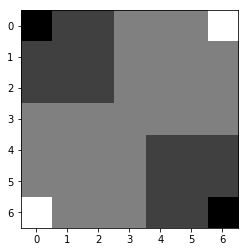

-0.01


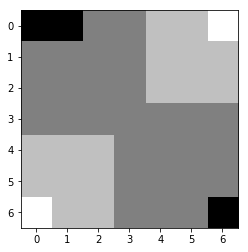

0.0


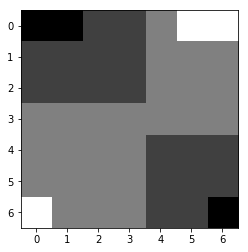

-0.01


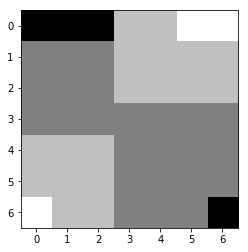

0.01


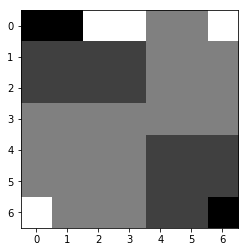

-0.04


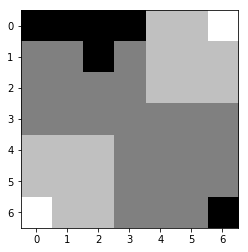

-0.02


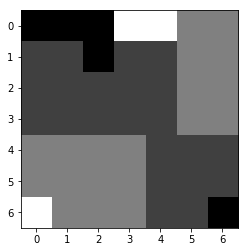

-0.07


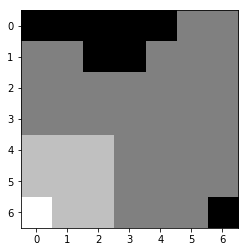

-0.06


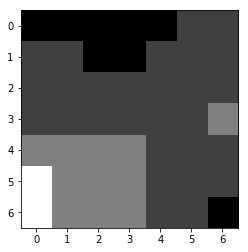

-0.07


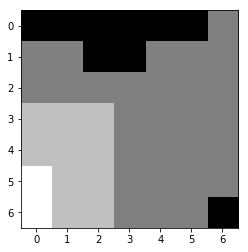

-0.06


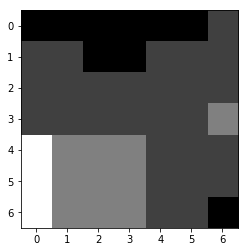

-0.08


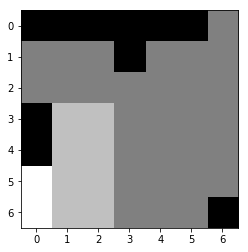

-0.03


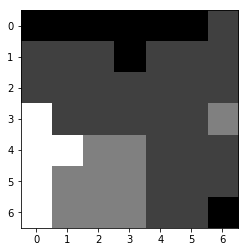

-0.09


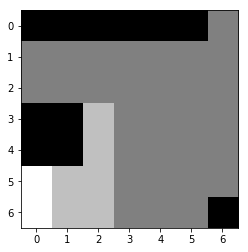

-0.04


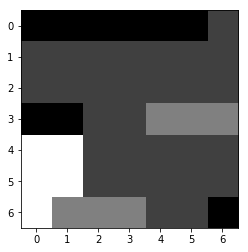

-0.09


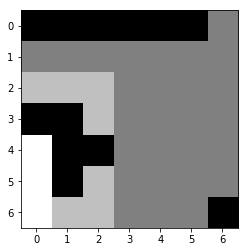

-0.03


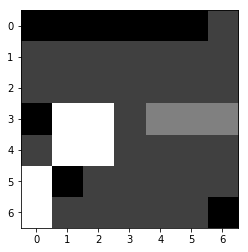

-0.1


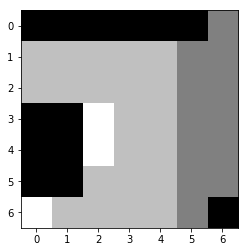

-0.04


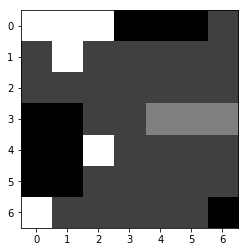

-0.11


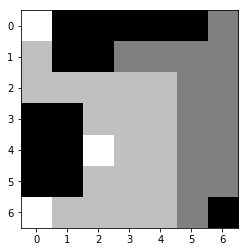

-0.03


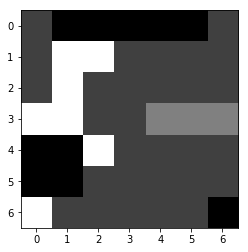

-0.11


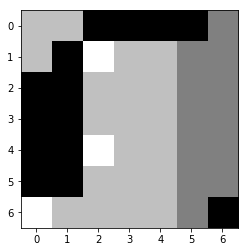

-0.04


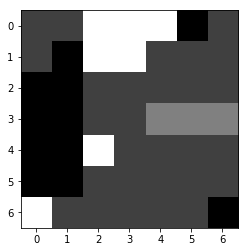

-0.11


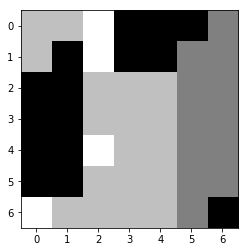

-0.02


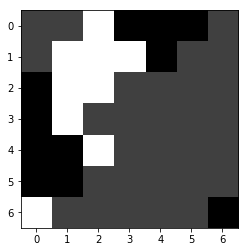

-0.11


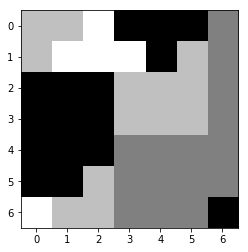

-0.04


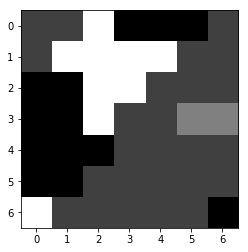

-0.11


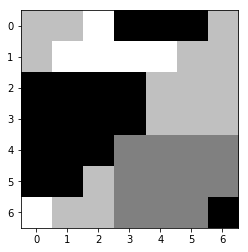

-0.05


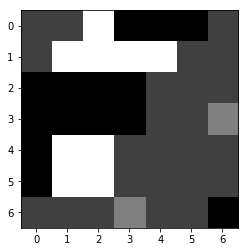

-0.11


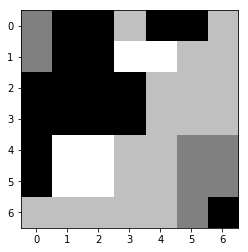

-0.04


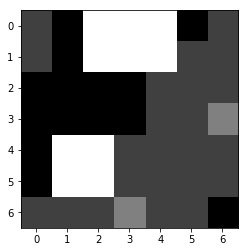

-0.09


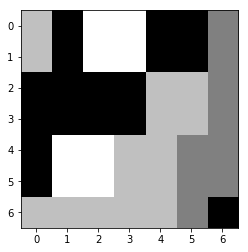

0.0


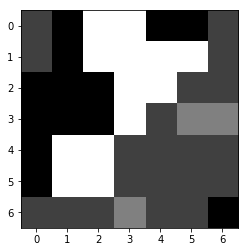

-0.07


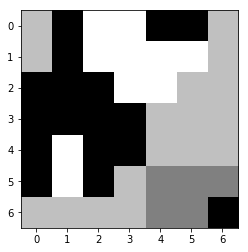

0.01


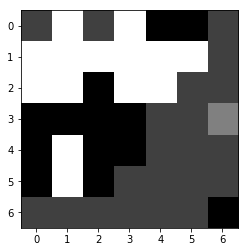

-0.09


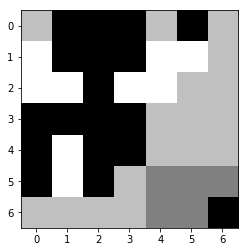

-0.02


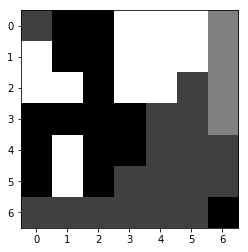

-0.08


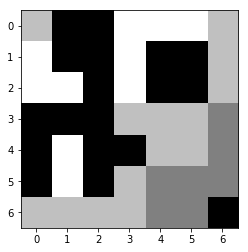

0.03


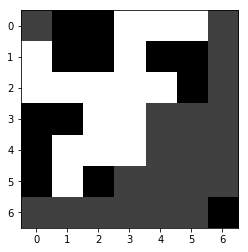

-0.06


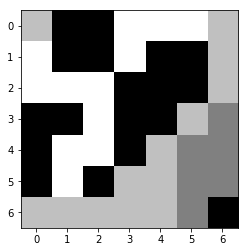

0.0


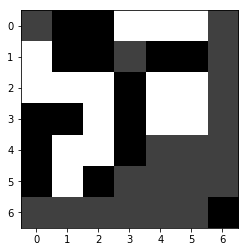

-0.09


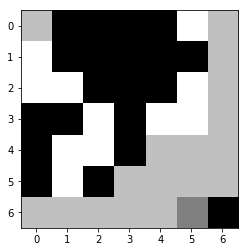

-0.04


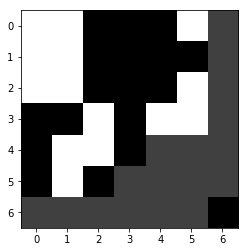

-0.09


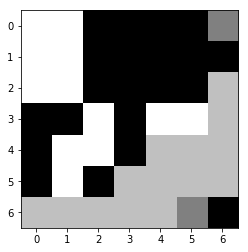

-0.02


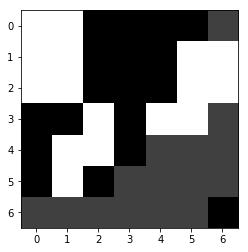

-0.08


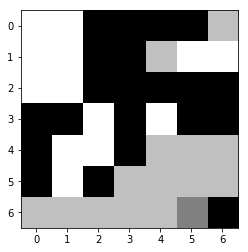

0.07


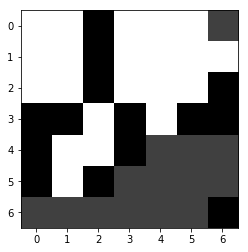

0.01


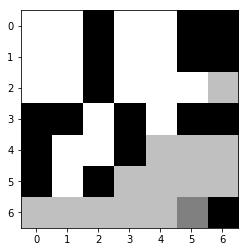

0.1


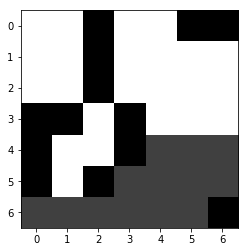

0.04


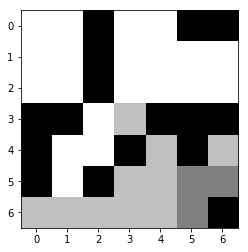

0.12


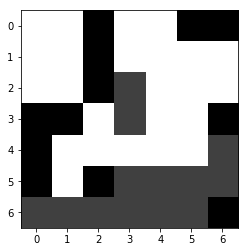

-0.01


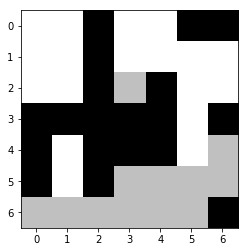

0.12


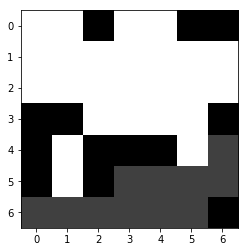

0.07


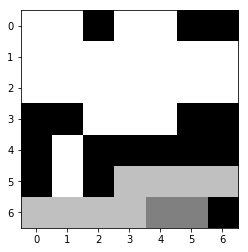

0.15


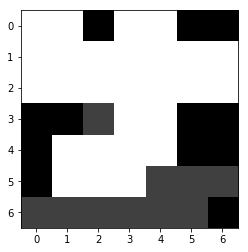

0.0


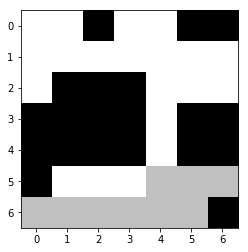

0.07


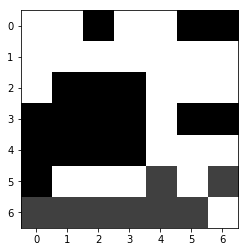

-0.02


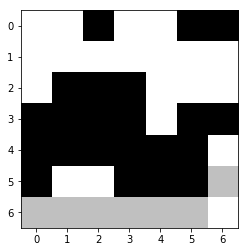

0.04


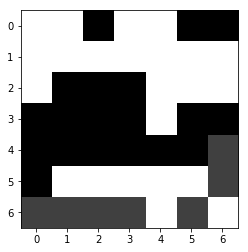

-0.04


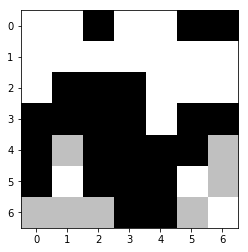

0.11


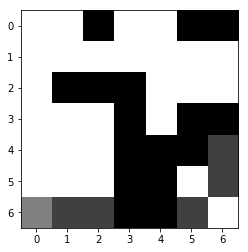

0.05


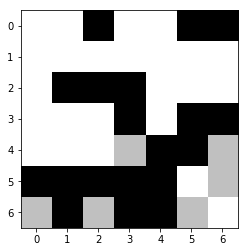

0.16


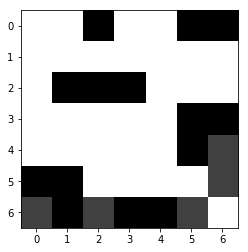

0.09


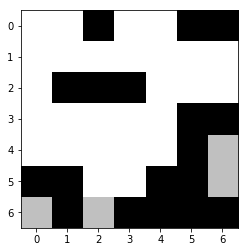

0.17


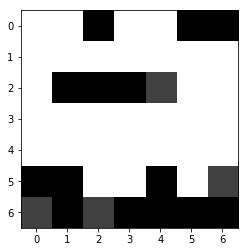

0.02


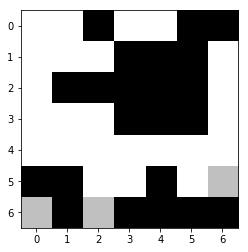

0.09


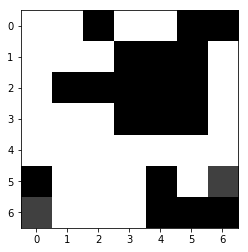

0.02


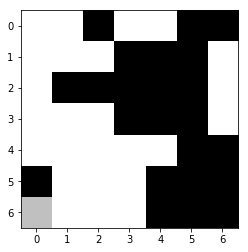

In [61]:
turn = -1
while abs(game.evaluate(1, turn)) != 10:
    print(game.evaluate(1, turn))
    game.plot(True, turn)
    best_move = game.get_greedy_move(turn)
    game.move_to(turn, best_move[0], best_move[1])
    turn = -turn
    time.sleep(0.1)